# Identifying Message Authors based on Message Content
#### Wilson Smith

_The existence of an algorithm to successfully identify message authors based on details of the message content can reduce anonymity to a certain degree. While this may be worrisome, it does not de-anonymize everybody. Particularly, because the model has to be trained to identify a specific actor by being trained on that same actor. So an individual can be targeted only if there is sufficient accessible data that can be linked to that individual already. Moving on._

The idea here is to identify who said which messages based on different properties of a message. These properties include, but are not limited to word choice and typos. All of these messages can come from social media platforms, message boards, forum sites, text messages, or wherever user-generated conversational text happens to be.

For this project, a set of python libraries will be used to collect, aggregate, process, and analyze the data. They are imported in this block of python code:

In [270]:
# data science
import pandas as pd
import numpy as np
import sklearn
from scipy import stats
from sklearn import linear_model

# plotting
import matplotlib.pyplot as plt

# data management
import sqlite3
import os
import json

# internet data collection
import requests

# utilities
import re
import datetime
import dateutil.parser
import time
from calendar import Calendar as cal

# this function exists because calendar's itermonthdates is not exclusive to the entered month.
def month_days(year, month):
    return map(
        lambda x: x.day,
        filter(
            lambda x: x.month == month,
            cal().itermonthdates(year, month)
        )
    )

In [231]:
# This notebook file is not at the root of the directory tree.
if not os.path.exists('.gitignore'):
    os.chdir('..')

----

## Data Collection & Cleaning

The directory structure of the data folder will be as follows:

```
data/
 ┣ irc/
 ┃ ┣ ubuntu_20150101.txt  logfile for #ubuntu on 01/01/2015
 ┃ ┃ ...
 ┃ ┗ ubuntu_20211231.txt  logfile for #ubuntu on 31/12/2021
 ┣ discord/
 ┃ ┣ token                authentication token for discord
 ┃ ┗ channel_ids          lists of chats to scrape
 ┣ irc.db                 sqlite3 database of messages from irc channels
 ┣ discord.db             sqlite3 database of messages from discord
 ┗ words                  local copy of a dictionary of words separated by newlines
```

This structure will be created with the following code:

In [232]:
def ensure_path(tree):
    for k,v in tree.items():
        if not os.path.exists(k):
            os.mkdir(k)
        os.chdir(k)
        ensure_path(v)
        os.chdir('..')
        
ensure_path({
    'data': {
        'irc': {},
        'discord': {},
    }
})

### IRC
IRC has four main types of channel messages:
1.  User messages (the most common).

    `(date) (sender name) (message content)`
   
    Some clients have a reply feature.
    It prefixes the message with the replied-to user's name.

2.  Status "/me" messages.

    `(date)  * (sender name) (message content)`
    
3.  Name change messages.

    `(system prefix) (old name) is now known as (new name)`
   
4.  System changes.

    This includes things like permissions and other miscellaneous moderation actions.
    In most conversation, they don't matter.

For this example, I've decided to use the archived versions of the `#ubuntu` IRC channel.

These are publically accessible at [irclogs.ubuntu.com](https://irclogs.ubuntu.com/).

First, to avoid abusing ubuntu's servers, a local cache of the relevant logfiles were made.

In [233]:
for year in range(2015, 2022):
    for month in range(1, 12 + 1):
        for day in month_days(2020, month):
            filename = f"data/irc/ubuntu_{year:04}{month:02}{day:02}.txt"
            if not os.path.exists(filename):
                try:
                    resp = requests.get(f"https://irclogs.ubuntu.com/{year:04}/{month:02}/{day:02}/%23ubuntu.txt")
                    if resp.status_code == 200:
                        with open(filename, 'w+') as f:
                            f.write(resp.text)
                except:
                    pass

Then unique ID is necessary for grouping the chat message authors by actor.

In [234]:
# (name, database) -> (database with name, index of name in database)
def name_to_id(name, db):
    for k,v in db.items():
        if name == v[-1]:
            return k
    new_id = len(db)
    db[new_id] = [name]
    return new_id

IRC user name change system message affect the unique ID calculation.

In [235]:
# (old name, new name, database) -> (database with names, index of name in database)
def renamed(name_old, name_new, db):
    for k,v in db.items():
        if name_old == v[-1]:
            v.append(name_new)
            return k
    for k,v in db.items():
        try:
            if name_old == v[-2]:
                if name_new == v[-1]:
                    return k
        except: pass
    new_id = len(db)
    db[new_id] = [name_old, name_new]
    return new_id

The grand total processing function:

In [236]:
# get the message log for `#ubuntu` for a particular day.
def irc_ubuntu_date(year, month, day, senders={}):
    filename = f"data/irc/ubuntu_{year:04}{month:02}{day:02}.txt"
    
    if not os.path.exists(filename):
        print(filename, "does not exist. 404?")
        return None
    
    with open(filename, 'r') as f:
        text = ''.join(f.readlines())
        
    df = pd.DataFrame(columns=[
        'date',
        'sender',
        'reply_to',
        'message'
    ])
    
    for line in text.split('\n'):
        
        match = re.search(r"^\[(\d\d):(\d\d)\] <([^>]+)>\s*(([^\s:]+):)?\s*(.*)$", line)
        if match:
            date = datetime.datetime(year, month, day, int(match[1]), int(match[2]))
            df = df.append({
                'date': date,
                'sender': name_to_id(match[3], senders),
                'reply_to': None if match[5] is None else name_to_id(match[5], senders),
                'message': match[6]
            }, ignore_index=True)
            continue
        
        match = re.search(r"=== (.+) is now known as (.+)$", line)
        if match:
            renamed(match[1], match[2], senders)
            continue
        
        match = re.search(r"^\[(\d\d):(\d\d)\]  \* ([^\s]+) (.*)$", line)
        if match:
            date = datetime.datetime(year, month, day, int(match[1]), int(match[2]))
            df = df.append({
                'date': date,
                'sender': name_to_id(match[3], senders),
                'reply_to': None,
                'message': match[4]
            }, ignore_index=True)
            continue
            
        if line == "":
            continue
        
        print('weird line format', line)

    return df, senders

Python [DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to store the scraped data for ease of manipulation.

In [237]:
df_irc_ubuntu = pd.DataFrame(columns=[
    'date',
    'sender',
    'reply_to',
    'message'
])
df_irc_ubuntu_names = pd.DataFrame(columns=[
    'id',
    'index',
    'name',
])

Pre-process all of 2015, then cache it to an sqlite database. If this database table already exists, load it (saves tens of hours).

[Some](https://irclogs.ubuntu.com/2015/05/22/%23ubuntu.txt) [dates](https://irclogs.ubuntu.com/2015/11/09/%23ubuntu.txt) are missing proper logfiles. More on this later.

In [238]:
conn = sqlite3.connect("data/irc.db")
year = 2015

try:
    df_irc_ubuntu = pd.read_sql_query(f"SELECT * FROM irc_ubuntu_{year}", conn)
    print(f"loaded df_irc_ubuntu_{year}")
    
    df_irc_ubuntu_names = pd.read_sql_query(f"SELECT * FROM irc_ubuntu_{year}_names", conn)
    print(f"loaded df_irc_ubuntu_{year}_names")
    
except:
    for month in range(1, 12 + 1):
        for day in month_days(year, month):
            messages, senders = irc_ubuntu_date(year, month, day, senders=sender_list)
            df_irc_ubuntu = df_irc_ubuntu.append(messages, ignore_index=True)
            print("processed", year, month, day)
            
    df_irc_ubuntu.to_sql(f"irc_ubuntu_{year}", conn)
    print(f"logged df_irc_ubuntu_{year}")

    for k,v in senders.items():
        for i,v in enumerate(v):
            df_irc_ubuntu_names = df_irc_ubuntu_names.append({
                'id': k,
                'index': i,
                'name': v,
            }, ignore_index=True)
    
    df_irc_ubuntu_names.to_sql(f"irc_ubuntu_{year}_names", conn)
    print(f"logged df_irc_ubuntu_{year}_names")

conn.close()

loaded df_irc_ubuntu_2015
loaded df_irc_ubuntu_2015_names


### Discord
Discord has several types of messages. They are stored and transferred in JSON format.
The [official documentation](https://discord.com/developers/docs/resources/channel#message-object) describes the general format for messages.

The fields relevant for this experiment are:
```
    {
        author: {
            id,                 internal user id
            name,               text display name
            bot?,               boolean: is the user a bot (optional)
            ...
        },
        content,                unformatted markdown message content
        attachments,            array of attachment objects which have links to the file.
        timestamp,              send time in ISO8601 format
        referenced_message?,    the message this message was sent as a reply to (optional)
        type,                   enum for what kind of message this is
        ...
    }
```
Fields labeled with a question mark `?` may not appear.

This format covers every potential message that can be viewed by users.
For this, messages with nonempty content will be used.

Message content can also include mentions of users in the format `<@USER_ID>` where `USER_ID` is the numeric internal user id. These will remain in the processed data set, as when an account's data is anonymized, the message content is completely unaltered.

The author object is calculated when the message is delivered to the client. Any updates to the author will show up in old messages. That being said, there is only one visible username at a time.

These messages are _not_ publically accessible. Consent per user that appears in any message was obtained.

In [239]:
def discord_channel_messages(authorization_token, channel_id):
    messages = []
    headers = {
        'User-Agent': 'I am scraping my own messages for a data science project. If you need to contact me, message me on this account.',
        'Accept': '*/*',
        'Authorization': authorization_token,
    }
    first_message = 0
    
    while True:
        resp = requests.get(
            f"https://discord.com/api/v9/channels/{channel_id}/messages?limit=100&after={first_message}",
            headers = headers
        )
        data = json.loads(resp.text)
        
        if isinstance(data, dict) and 'retry_after' in data.keys():
            time.sleep(data['retry_after'] + 1)
            continue
        
        messages += data
        first_message = data[0]['id']
        
        if len(data) < 100:
            break
    
    return [
        [
            dateutil.parser.isoparse(m['timestamp']),
            m['author']['id'],
            m['content'],
            not not m['edited_timestamp'],
        ] for m in messages
    ]

Load private authentication and location parameters:

`data/discord/token` is your user authentication token to access your data on Discord.

`data/discord/channel_ids` is a list of channel IDs to scrape all the messages from.

In [240]:
with open('data/discord/token', 'r') as f:
    discord_token = ''.join(f.readlines()).strip()
    
with open('data/discord/channel_ids', 'r') as f:
    discord_channels = [cid.strip() for cid in f.readlines() if len(cid) > 2]

Proceeding to log and cache the data:

In [241]:
conn_discord = sqlite3.connect("data/discord.db")

discord_all = {}

for index, channel in enumerate(discord_channels):
    try:
        discord_all[index] = pd.read_sql_query(f"SELECT * FROM discord_{channel}", conn_discord)
        print(f"loaded channel #{index}")
        
    except:
        discord_all[index] = pd.DataFrame(
            data = discord_channel_messages(discord_token, channel),
            columns=[
                'date',
                'sender',
                'message',
                'edited',
            ]
        )
        discord_all[index].to_sql(f"discord_{channel}", conn_discord)
        print(f"logged channel #{index}")

conn_discord.close()

loaded channel #0
loaded channel #1
loaded channel #2
loaded channel #3


### Missing data?
For IRC, some days were missing logfiles.
Imputing enough data to fill the gaps is very difficult considering the number of parameters.
The gaps will be used as boundaries.

For Discord, some messages may have been deleted or edited.
In the case of a deleted message, there is no evidence of it.
So the likelihood of missing context or messages will have to be accounted for in the model.
In the case of an editied message, the most frequent is a spelling correction.
Because the actor who wrote the original message also edited the message, it should not matter so much what changed.

In short, the missing data can't reliably be recovered.

### Incorrect data?
It is possible that data may be incorrect. There are a few ways that come to mind:
1. logfiles with mislabeled dates
2. name matching/impersonation of a user
3. quoting
4. manipulation by platform administrator

For mislabeling, this can be solved by looking at each day individually.
For the collected data, it can only be a problem for IRC.

Impersonation is harder to solve.
If "Tom" disconnects, unless he was a registered user, someone else may connect with the name "Tom" in IRC.
Multiple people may also use the same account, so there may be some sort of bimodal distribution of features for one account.

For quoting, in IRC, it is infrequent due to the message size limitations. In Discord, the quote user feature is builtin, and shows up in a different field from the message content. So this shouldn't be a direct issue in conflict between users. It may only appear if two users quote the same material. But this should be accounted for by a model.

For administrator manipulation, nothing can be done. This is highly unlikely on smaller 1-to-1 message logs, but may exist on IRC platforms if someone posts something against the platform's terms of service for one reason or another.

----

## Exploratory Data Analysis

Now that the data has been aggregated successfully, we should analyze different properties of the messages to build a proper and functional model that can (somewhat) reliably determine which actor sent which message. For that, we need to calculate some statistics regarding the data set.

To start, we will define what we mean by common terms for lingustic analyses:
- document: an individual message
- corpus: the entire conversation (over some range)
- author/actor: message sender

As a precursor, the way that words are extracted from a document is abstracted out for standardization.

Note that some of the data may include URLs, so they show up once or twice on average. Let's map these to the domain name.

In [425]:
def words(document):
    terms = re.split(r"[\s]+", document.lower())
    domains = list(map(
        lambda x: re.match(r'https://([^/]+)', x)[1],
        filter(
            lambda x: re.match(r'https://.+',x),
            terms
        )
    ))
    words = list(filter(
        lambda x: None == re.match(r'https://.+', x),
        terms
    ))
    return words + domains

And a method to split a string into a list of individual characters.

In [426]:
def ngrams(document, size=1):
    return re.split("(" + "." * size + ")", document)[1::2]

And a standard list of words that are spelled correctly.

In [427]:
with open("data/words", "r") as f:
    vocabulary_standard = [l.strip() for l in f.readlines()]

First, a function to count the term frequency in a list is constructed.

In [428]:
def word_frequency_list(series):
    vocabulary = {}
    for document in series:
        for word in words(document):
            if not (word in vocabulary):
                vocabulary[word] = 1
            else:
                vocabulary[word] += 1
    return vocabulary

def ngram_frequency_list(series, size=1):
    chars = {}
    for document in series:
        for char in ngrams(document, size=size):
            if not (char in chars):
                chars[char] = 1
            else:
                chars[char] += 1
    return chars

The current dataset will be chosen by the block here:

In [429]:
dataset = discord_all[3]

To check if there is enough data for good-enough statistical approximations, a well-known metric, [N-gram frequency](https://norvig.com/mayzner.html), will be tested against the data. In any sample of text, given it is large enough, the most common letters should be in the following order: E, T, A, O, I, N, ...

In [430]:
letter_frequency_in_corpus = pd.DataFrame(
    data = np.array(list(
        ngram_frequency_list(
            dataset['message']
        ).items()
    )),
    columns = [
        'word',
        'freq',
    ]
)

mu = {}
mu['e'] = 0.1249
mu['t'] = 0.0928
mu['a'] = 0.0804
mu['o'] = 0.0764
mu['i'] = 0.0757
mu['n'] = 0.0723
mu['s'] = 0.0651
mu['r'] = 0.0628
mu['h'] = 0.0505
mu['l'] = 0.0407
mu['d'] = 0.0382
mu['c'] = 0.0334
mu['u'] = 0.0273
mu['m'] = 0.0251
mu['f'] = 0.0240
mu['p'] = 0.0214
mu['g'] = 0.0187
mu['w'] = 0.0168
mu['y'] = 0.0166
mu['b'] = 0.0148
mu['v'] = 0.0105
mu['k'] = 0.0054
mu['x'] = 0.0023
mu['j'] = 0.0016
mu['q'] = 0.0012
mu['z'] = 0.0009
mu_n = 3563505777820 # super large n (3 trillion), so stddev is basically 0

mu_df = pd.DataFrame(
    data = np.array(list(mu.items())),
    columns = [
        'word',
        'pfreq(standard)',
    ]
)

n_ = letter_frequency_in_corpus['freq'].astype(int).sum()
comparison = pd.merge(
    letter_frequency_in_corpus,
    mu_df,
    on = 'word',
    how = 'right',
).fillna(0)

comparison['pfreq'] = comparison['freq'].astype(float) / comparison['freq'].astype(float).sum()
comparison['pfreq(standard)'] = comparison['pfreq(standard)'].astype(float) / comparison['pfreq(standard)'].astype(float).sum()

comparison['pdiff'] = comparison['pfreq'] - comparison['pfreq(standard)']

letter_frequency_in_corpus['pfreq'] = letter_frequency_in_corpus['freq'].astype(float) / n_
letter_frequency_in_corpus['freq'] = letter_frequency_in_corpus['freq'].astype(int)
letter_frequency_in_corpus = letter_frequency_in_corpus.sort_values(
    by = 'freq',
    ascending = False,
    ignore_index = True
)

comparison.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
word,e,t,a,o,i,n,s,r,h,l,d,c,u,m,f,p,g,w,y,b
freq,119159,101499,89537,99159,81991,71347,75006,51985,65049,49094,45080,28071,40452,36845,19095,21452,26657,31703,34561,21156
pfreq(standard),0.124925,0.092819,0.080416,0.076415,0.075715,0.072314,0.065113,0.062813,0.05051,0.040708,0.038208,0.033407,0.027305,0.025105,0.024005,0.021404,0.018704,0.016803,0.016603,0.014803
pfreq,0.103272,0.087967,0.0776,0.085939,0.07106,0.061835,0.065006,0.045054,0.056376,0.042549,0.03907,0.024328,0.035059,0.031933,0.016549,0.018592,0.023103,0.027476,0.029953,0.018335
pdiff,-0.021653,-0.004852,-0.002816,0.009524,-0.004655,-0.01048,-0.000107,-0.017758,0.005866,0.001841,0.000862,-0.009078,0.007753,0.006828,-0.007456,-0.002812,0.004399,0.010673,0.01335,0.003532


We can get the z-scores for each 
$$
    \frac {
        \bar{x} - \mu
    } {
        \sigma_x
    }
    =
    \frac {
        \hat{p}_1 - \hat{p}_2
    } {
        \sqrt {
            \hat{p} (1 - \hat{p}) \left( \frac {
                1
            } {
                n_1
            } + \frac {
                1
            } {
                n_2
            } \right)
        }
    }
$$


$$
    \hat{p}
    =
    \frac {
        x_1 + x_2
    } {
        n_1 + n_2
    }
$$

In [431]:
comparison['freq(standard)'] = mu_n * comparison['pfreq(standard)'].astype(float)
comparison['freq'] = comparison['freq'].astype(float)

n__ = comparison['freq'].sum()
comparison['ppool'] = ( \
    (comparison['freq(standard)'] + comparison['freq'])    \
    / (mu_n + n__)                                         \
).astype(float)

comparison['zdiff'] = comparison['pdiff'] / \
    np.sqrt( \
        comparison['ppool'] * (1 - comparison['ppool']) * ((1 / n__) + (1 / mu_n))
    )

comparison.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
word,e,t,a,o,i,n,s,r,h,l,d,c,u,m,f,p,g,w,y,b
freq,119159.0,101499.0,89537.0,99159.0,81991.0,71347.0,75006.0,51985.0,65049.0,49094.0,45080.0,28071.0,40452.0,36845.0,19095.0,21452.0,26657.0,31703.0,34561.0,21156.0
pfreq(standard),0.124925,0.092819,0.080416,0.076415,0.075715,0.072314,0.065113,0.062813,0.05051,0.040708,0.038208,0.033407,0.027305,0.025105,0.024005,0.021404,0.018704,0.016803,0.016603,0.014803
pfreq,0.103272,0.087967,0.0776,0.085939,0.07106,0.061835,0.065006,0.045054,0.056376,0.042549,0.03907,0.024328,0.035059,0.031933,0.016549,0.018592,0.023103,0.027476,0.029953,0.018335
pdiff,-0.021653,-0.004852,-0.002816,0.009524,-0.004655,-0.01048,-0.000107,-0.017758,0.005866,0.001841,0.000862,-0.009078,0.007753,0.006828,-0.007456,-0.002812,0.004399,0.010673,0.01335,0.003532
freq(standard),445170905830.884155,330759488079.311829,286563177172.162415,272306302685.985168,269811349650.904205,257693006337.653564,232030632262.534546,223832929432.982544,179993040387.98761,145063697896.853363,136153151342.992584,119044901959.57991,97303168368.159637,89461887400.762146,85541246917.0634,76274278501.048203,66650888222.878586,59878872841.944382,59166029117.635529,52750435598.855774
ppool,0.124925,0.092819,0.080416,0.076415,0.075715,0.072314,0.065113,0.062813,0.05051,0.040708,0.038208,0.033407,0.027305,0.025105,0.024005,0.021404,0.018704,0.016803,0.016603,0.014803
zdiff,-70.345073,-17.959709,-11.124951,38.507255,-18.903158,-43.461481,-0.465955,-78.620753,28.774502,10.004473,4.831132,-54.266474,51.103266,46.8799,-52.321577,-20.872953,34.880934,89.194021,112.224523,31.420504


The z-scores are pretty far from zero, so this might be a characteristic that can identify someone. Let's see if at least the standard ordering matches the data.

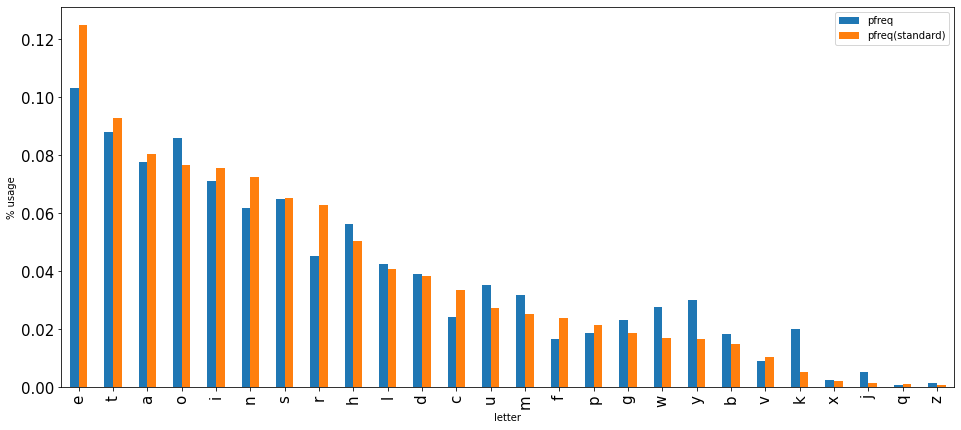

In [432]:
ax = comparison.set_index('word')[['pfreq', 'pfreq(standard)']].plot.bar(
    figsize = (16, 7),
    xlabel = 'letter',
    ylabel = '% usage',
    fontsize = 15,
)

It matches up pretty well, in terms of ordering, but not so much in the exact proportions. The first common character is the content of an empty message (which is the default content for a message with an attachment). So the data we obtained is good enough for further statistical analysis.

Let's try to see if there is a significant difference in the letter distribution by author.

In [433]:
for index, sender in enumerate(dataset['sender'].unique()):
    letter_frequency_by_sender = pd.DataFrame(
        data = np.array(list(
            ngram_frequency_list(
                dataset[dataset['sender'] == sender]['message']
            ).items()
        )),
        columns = [
            'word',
            f"freq({index})",
        ]
    )
    letter_frequency_in_corpus = pd.merge(
        letter_frequency_in_corpus,
        letter_frequency_by_sender,
        on = 'word',
        how = 'left',
    )
    letter_frequency_by_sender[f"freq({index})"] = letter_frequency_by_sender[f"freq({index})"].astype(int)

letter_frequency_in_corpus.fillna(0, inplace=True)

letter_frequency_in_corpus.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
word,,e,t,o,a,i,s,n,h,r,l,d,u,m,y,w,c,g,k,p
freq,230726,119159,101499,99159,89537,81991,75006,71347,65049,51985,49094,45080,40452,36845,34561,31703,28071,26657,23181,21452
pfreq,0.151302,0.07814,0.06656,0.065025,0.058715,0.053767,0.049186,0.046787,0.042657,0.03409,0.032194,0.029562,0.026527,0.024162,0.022664,0.02079,0.018408,0.017481,0.015201,0.014067
freq(0),122959,64490,54680,52657,48043,40198,38380,38015,32670,28542,24709,22587,21273,18245,17417,15491,15916,14148,10043,12187
freq(1),107767,54669,46819,46502,41494,41793,36626,33332,32379,23443,24385,22493,19179,18600,17144,16212,12155,12509,13138,9265


Let's see if there is a difference when we look at the difference in the measures. Normalizing the values should help us here.

In [434]:
n = {}
for index, sender in enumerate(dataset['sender'].unique()):
    n[index] = letter_frequency_in_corpus[f"freq({index})"].astype(int).sum()
    letter_frequency_in_corpus[f"pfreq({index})"] = \
        letter_frequency_in_corpus[f"freq({index})"].astype(float) / n[index]



letter_frequency_in_corpus.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
word,,e,t,o,a,i,s,n,h,r,l,d,u,m,y,w,c,g,k,p
freq,230726,119159,101499,99159,89537,81991,75006,71347,65049,51985,49094,45080,40452,36845,34561,31703,28071,26657,23181,21452
pfreq,0.151302,0.07814,0.06656,0.065025,0.058715,0.053767,0.049186,0.046787,0.042657,0.03409,0.032194,0.029562,0.026527,0.024162,0.022664,0.02079,0.018408,0.017481,0.015201,0.014067
freq(0),122959,64490,54680,52657,48043,40198,38380,38015,32670,28542,24709,22587,21273,18245,17417,15491,15916,14148,10043,12187
freq(1),107767,54669,46819,46502,41494,41793,36626,33332,32379,23443,24385,22493,19179,18600,17144,16212,12155,12509,13138,9265
pfreq(0),0.156719,0.082196,0.069693,0.067115,0.061234,0.051235,0.048918,0.048452,0.04164,0.036379,0.031493,0.028789,0.027114,0.023254,0.022199,0.019744,0.020286,0.018032,0.0128,0.015533
pfreq(1),0.145562,0.073842,0.063239,0.062811,0.056046,0.05645,0.049471,0.045022,0.043735,0.031665,0.032937,0.030382,0.025905,0.025123,0.023157,0.021898,0.016418,0.016896,0.017746,0.012514


In [435]:
letter_frequency_in_corpus['delta_freq(0-1)'] = \
    letter_frequency_in_corpus['freq(0)'].astype(float) - letter_frequency_in_corpus['freq(1)'].astype(float)

letter_frequency_in_corpus.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
word,,e,t,o,a,i,s,n,h,r,l,d,u,m,y,w,c,g,k,p
freq,230726,119159,101499,99159,89537,81991,75006,71347,65049,51985,49094,45080,40452,36845,34561,31703,28071,26657,23181,21452
pfreq,0.151302,0.07814,0.06656,0.065025,0.058715,0.053767,0.049186,0.046787,0.042657,0.03409,0.032194,0.029562,0.026527,0.024162,0.022664,0.02079,0.018408,0.017481,0.015201,0.014067
freq(0),122959,64490,54680,52657,48043,40198,38380,38015,32670,28542,24709,22587,21273,18245,17417,15491,15916,14148,10043,12187
freq(1),107767,54669,46819,46502,41494,41793,36626,33332,32379,23443,24385,22493,19179,18600,17144,16212,12155,12509,13138,9265
pfreq(0),0.156719,0.082196,0.069693,0.067115,0.061234,0.051235,0.048918,0.048452,0.04164,0.036379,0.031493,0.028789,0.027114,0.023254,0.022199,0.019744,0.020286,0.018032,0.0128,0.015533
pfreq(1),0.145562,0.073842,0.063239,0.062811,0.056046,0.05645,0.049471,0.045022,0.043735,0.031665,0.032937,0.030382,0.025905,0.025123,0.023157,0.021898,0.016418,0.016896,0.017746,0.012514
delta_freq(0-1),15192.0,9821.0,7861.0,6155.0,6549.0,-1595.0,1754.0,4683.0,291.0,5099.0,324.0,94.0,2094.0,-355.0,273.0,-721.0,3761.0,1639.0,-3095.0,2922.0


Now we need to determine the overall word frequency

In [436]:
word_frequency_in_corpus = pd.DataFrame(
    data = np.array(list(
        word_frequency_list(
            dataset['message']
        ).items()
    )),
    columns = [
        'word',
        'freq',
    ]
)

total_vocabulary = word_frequency_in_corpus['word']

word_frequency_in_corpus['freq'] = word_frequency_in_corpus['freq'].astype(int)
word_frequency_in_corpus = word_frequency_in_corpus.sort_values(
    by = 'freq',
    ascending = False,
    ignore_index = True
)

for index, sender in enumerate(dataset['sender'].unique()):
    word_frequency_by_sender = pd.DataFrame(
        data = np.array(list(
            word_frequency_list(
                dataset[dataset['sender'] == sender]['message']
            ).items()
        )),
        columns = [
            'word',
            f"freq({index})",
        ]
    )
    word_frequency_by_sender[f"freq({index})"] = word_frequency_by_sender[f"freq({index})"].astype(int)
    word_frequency_in_corpus = pd.merge(
        word_frequency_in_corpus,
        word_frequency_by_sender,
        on = 'word',
        how = 'left',
    )

word_frequency_in_corpus.fillna(0, inplace=True)

word_frequency_in_corpus.head(10).T

,0,1,2,3,4,5,6,7,8,9
word,i,the,it,to,a,you,and,like,is,ok
freq,11719,6261,5743,5148,4806,4682,3801,3378,3239,2960
freq(0),4765.0,3789.0,3002.0,2728.0,2656.0,3510.0,1581.0,1088.0,1897.0,1156.0
freq(1),6954.0,2472.0,2741.0,2420.0,2150.0,1172.0,2220.0,2290.0,1342.0,1804.0


Second, a function to count how many times a set of words occurs in a sentence.

Words that do not appear in the dictionary. This includes URLs, IPs, typos, abbreviations, numbers, and punctuation.

In [437]:
word_frequency_in_corpus['spelled_correctly'] = word_frequency_in_corpus['word'].isin(vocabulary_standard)
word_frequency_in_corpus[~word_frequency_in_corpus['spelled_correctly']].head(10).T

,9,17,22,23,33,37,41,59,65,72
word,ok,lol,im,,dont,lmao,idk,?,thats,didnt
freq,2960,2388,2233,2130,1417,1307,1182,763,673,600
freq(0),1156.0,901.0,695.0,1098.0,534.0,378.0,350.0,322.0,304.0,260.0
freq(1),1804.0,1487.0,1538.0,1032.0,883.0,929.0,832.0,441.0,369.0,340.0
spelled_correctly,False,False,False,False,False,False,False,False,False,False


Words with dictionary-correct spellings:

In [438]:
word_frequency_in_corpus[word_frequency_in_corpus['spelled_correctly']].head(10).T

,0,1,2,3,4,5,6,7,8,10
word,i,the,it,to,a,you,and,like,is,that
freq,11719,6261,5743,5148,4806,4682,3801,3378,3239,2842
freq(0),4765.0,3789.0,3002.0,2728.0,2656.0,3510.0,1581.0,1088.0,1897.0,1465.0
freq(1),6954.0,2472.0,2741.0,2420.0,2150.0,1172.0,2220.0,2290.0,1342.0,1377.0
spelled_correctly,True,True,True,True,True,True,True,True,True,True


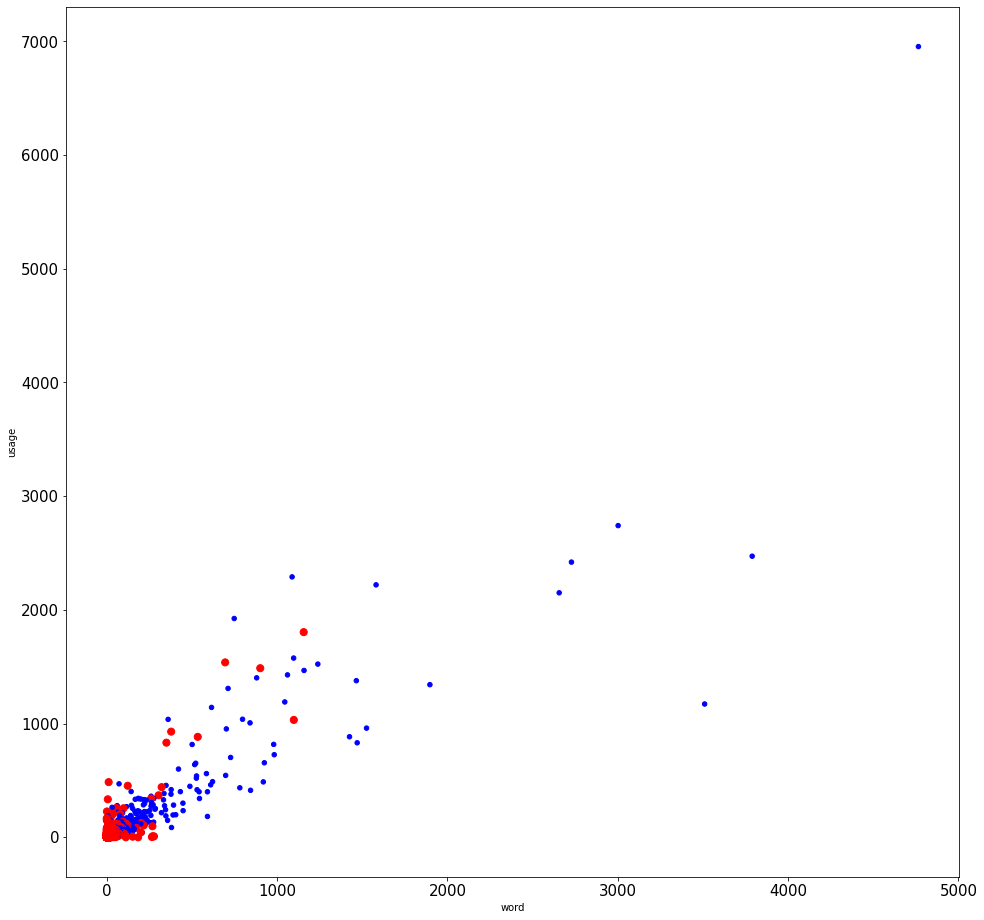

In [439]:
word_frequency_in_corpus['c'] = word_frequency_in_corpus['spelled_correctly'].map({True:'blue',False:'red'})
word_frequency_in_corpus['s'] = word_frequency_in_corpus['spelled_correctly'].map({True:20,False:50})
ax = word_frequency_in_corpus[['freq(0)', 'freq(1)', 'c', 's']].plot.scatter(
    figsize = (16, 16),
    x = 'freq(0)',
    y = 'freq(1)',
    xlabel = 'word',
    ylabel = 'usage',
    fontsize = 15,
    c = 'c',
    s = 's',
)

# for k, v in words_nodictionary.set_index('word')[['freq(0)', 'freq(1)']].astype(int).iterrows():
#     ax.annotate(k[0:6], (v['freq(0)'], v['freq(1)']))

So it looks like there are more non-dictionary words by one user (go figure). Let's look at the less frequent numbers.

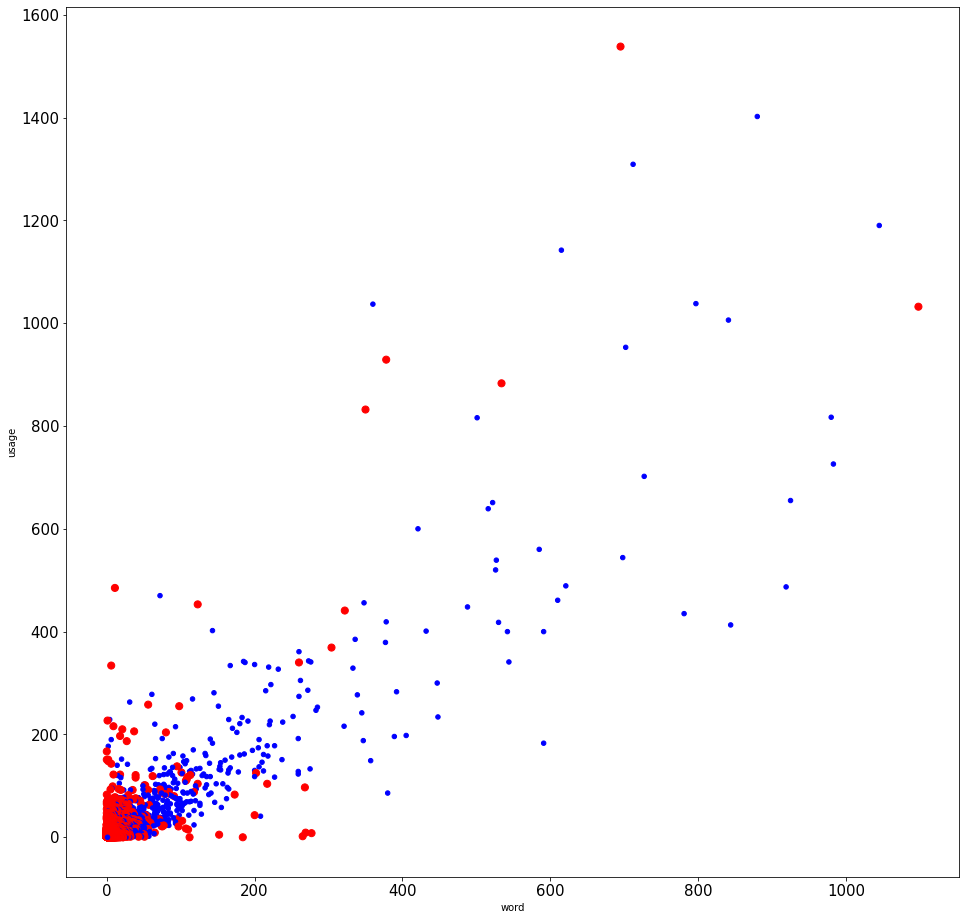

In [442]:
ax = word_frequency_in_corpus[['freq(0)', 'freq(1)', 'c', 's']].iloc[20:-10].plot.scatter(
    figsize = (16, 16),
    x = 'freq(0)',
    y = 'freq(1)',
    xlabel = 'word',
    ylabel = 'usage',
    fontsize = 15,
    c = 'c',
    s = 's',
)

So there are some values that do not fall on the $\text{freq}(0)=\text{freq}(1)$ line. This means that there are some values that can be used to identify who is who. Let's normalize the vectors and find the ones that fall farthest from the diagonal.

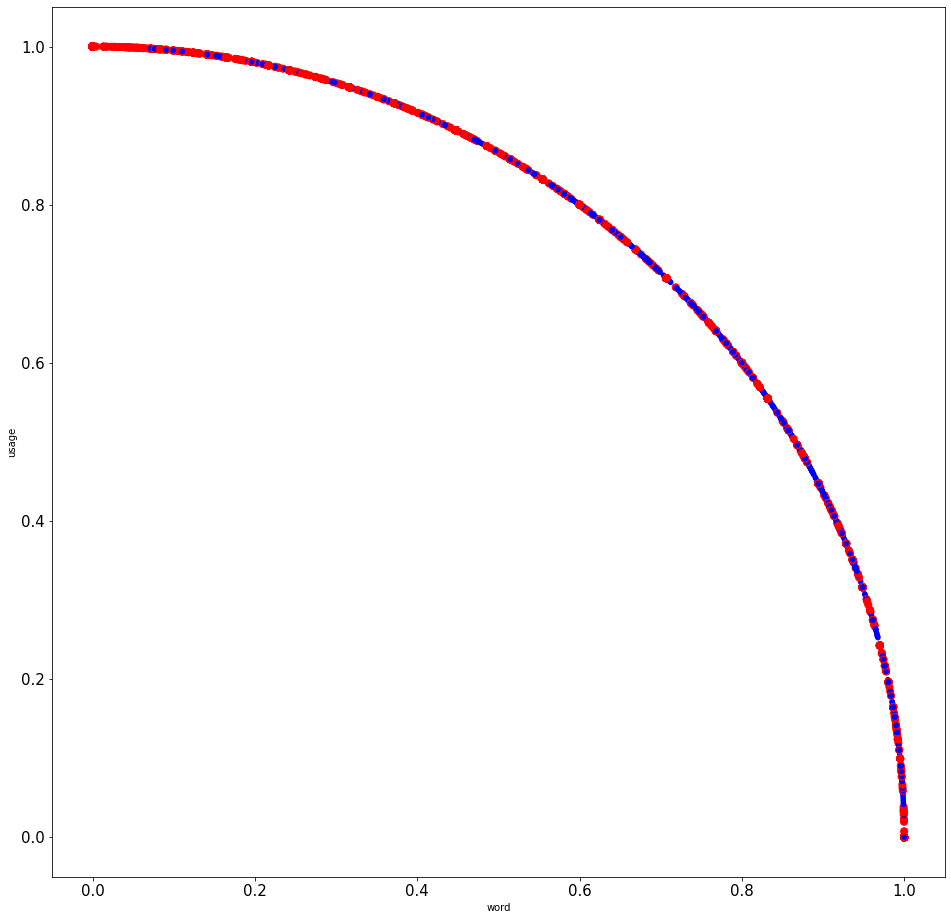

In [443]:
word_frequency_in_corpus['freq'] = word_frequency_in_corpus['freq'].astype(float)

for col in word_frequency_in_corpus.columns:
    if re.match(r"freq\(\d+\)", col):
        word_frequency_in_corpus[col] = word_frequency_in_corpus[col].astype(float)
        
        word_frequency_in_corpus[f"norm_{col}"] = \
        word_frequency_in_corpus[col] / np.sqrt(
            (word_frequency_in_corpus[col] ** 2) + \
            (word_frequency_in_corpus['freq'] - word_frequency_in_corpus[col]) ** 2
        )
        
ax = word_frequency_in_corpus[['norm_freq(0)', 'norm_freq(1)', 'c', 's']].iloc[20:-10].plot.scatter(
    figsize = (16, 16),
    x = 'norm_freq(0)',
    y = 'norm_freq(1)',
    xlabel = 'word',
    ylabel = 'usage',
    fontsize = 15,
    c = 'c',
    s = 's',
)

This graph doesn't do much to show anything other than the second user in the comparison uses words not in the dictionary more often. 

Now, let's figure out the percentage of words in the dictionary per user. This should give us some sort of metric.

In [473]:
n_correct = {}
n_total

word_frequency_in_corpus['spelled_correctly'] = word_frequency_in_corpus['spelled_correctly'].map(bool)

n_correct['total'] = word_frequency_in_corpus['spelled_correctly'].sum()

for col in word_frequency_in_corpus.columns:
    if re.match(r"^freq\(\d+\)", col):
        n_correct[col] = \
        word_frequency_in_corpus[word_frequency_in_corpus[col] > 0]['spelled_correctly'].sum() / n_correct['total']

n_correct

{'total': 7776, 'freq(0)': 0.8306327160493827, 'freq(1)': 0.6036522633744856}

This looks like there is a lot of spread, so it is indeed a good metric.

For the last part to prepare the data, we need to remove words that occur only once in order to prevent overfitting. 1/0 and 0/1 are pretty extreme proportions and their lack of reuse indicates they are not so significant. We will only use words that occur at least 8 times. This number was chosen by die roll.

In [480]:
reduced_word_frequency_in_corpus = word_frequency_in_corpus.copy()
for col in word_frequency_in_corpus.columns:
    if re.match(r"^freq\(\d+\)", col):
        reduced_word_frequency_in_corpus = reduced_word_frequency_in_corpus[reduced_word_frequency_in_corpus[col] > 8]

reduced_word_frequency_in_corpus

,word,freq,freq(0),freq(1),spelled_correctly,c,s,norm_freq(0),norm_freq(1)
0,i,11719.0,4765.0,6954.0,True,blue,20,0.565249,0.824920
1,the,6261.0,3789.0,2472.0,True,blue,20,0.837518,0.546409
2,it,5743.0,3002.0,2741.0,True,blue,20,0.738480,0.674275
3,to,5148.0,2728.0,2420.0,True,blue,20,0.748075,0.663615
4,a,4806.0,2656.0,2150.0,True,blue,20,0.777259,0.629181
...,...,...,...,...,...,...,...,...,...
1400,near,19.0,9.0,10.0,True,blue,20,0.668965,0.743294
1404,netflix,19.0,9.0,10.0,False,red,50,0.668965,0.743294
1411,tv,19.0,9.0,10.0,False,red,50,0.668965,0.743294
1436,aaa,18.0,9.0,9.0,False,red,50,0.707107,0.707107


One statistic to better normalize the words that comes to mind is the usage freqency of particular words. A good statistic for this is [term frequency-inverse document frequency](http://tfidf.com/). This ranks each word based on the frequency in a message, weighted by the relative importance in the entire conversation. This could be used given more computational power.

$$\text{number of times }\textit{word}\text{ appears in the document} \cdot \ln\left(\frac{\text{number of documents in corpus}}{\text{number of documents with }\textit{word}\text{ in it}}\right)$$

----

## Fitting Model